## Setup Preparation

In [1]:
from pyspark.sql import SparkSession

In [2]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [3]:
spark = SparkSession.builder.master("yarn").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/22 23:50:25 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [4]:
spark.sparkContext._conf.getAll()

[('spark.driver.appUIAddress', 'http://0112b8206f03:4040'),
 ('spark.app.startTime', '1703278222345'),
 ('spark.driver.port', '44357'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '0112b8206f03'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.submitTime', '1703278222147'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.bas

In [5]:
# Redefine config as we please
conf = spark.sparkContext._conf.setAll(
    [('spark.executor.memory', '1g'), 
     ('spark.app.name', 'Artamonov_spark'), 
     ('spark.executor.cores', '2'), 
     ('spark.executor.instances', '2'),
     ('spark.cores.max', '2')])

In [6]:
spark.sparkContext.stop()

23/12/22 23:50:55 WARN Dispatcher: Message RequestMessage(172.21.0.6:49800, NettyRpcEndpointRef(spark://CoarseGrainedScheduler@0112b8206f03:44357), RemoveExecutor(2,Unable to create executor due to Exception thrown in awaitResult: )) dropped due to sparkEnv is stopped. Could not find CoarseGrainedScheduler.


In [7]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

23/12/22 23:50:55 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


## Data preparation

In [8]:
!ls ../data

PrinciplesOfLazersZvelto.pdf  SW_EpisodeV.txt	ml-latest-small
SW_EpisodeIV.txt	      SW_EpisodeVI.txt	rubrics.json


In [9]:
!hadoop fs -put -f ../data/ml-latest-small/* /ml-latest-small

In [10]:
!hadoop fs -ls /ml-latest-small

Found 5 items
-rw-r--r--   3 root supergroup       8342 2023-12-22 23:51 /ml-latest-small/README.txt
-rw-r--r--   3 root supergroup     197979 2023-12-22 23:51 /ml-latest-small/links.csv
-rw-r--r--   3 root supergroup     494431 2023-12-22 23:51 /ml-latest-small/movies.csv
-rw-r--r--   3 root supergroup    2483723 2023-12-22 23:51 /ml-latest-small/ratings.csv
-rw-r--r--   3 root supergroup     118660 2023-12-22 23:51 /ml-latest-small/tags.csv


## Reading tables

In [11]:
%%time
ratings_df = spark.read.format("csv").option("header", "True").load("/ml-latest-small/ratings.csv")

CPU times: user 6.94 ms, sys: 1.03 ms, total: 7.97 ms
Wall time: 11.7 s


In [12]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [13]:
%%time
tags_df = spark.read.format("csv").option("header", "True").load("/ml-latest-small/tags.csv")

CPU times: user 3.68 ms, sys: 0 ns, total: 3.68 ms
Wall time: 578 ms


In [14]:
tags_df.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [15]:
ratings_df.count()

100836

In [16]:
tags_df.count()

3683

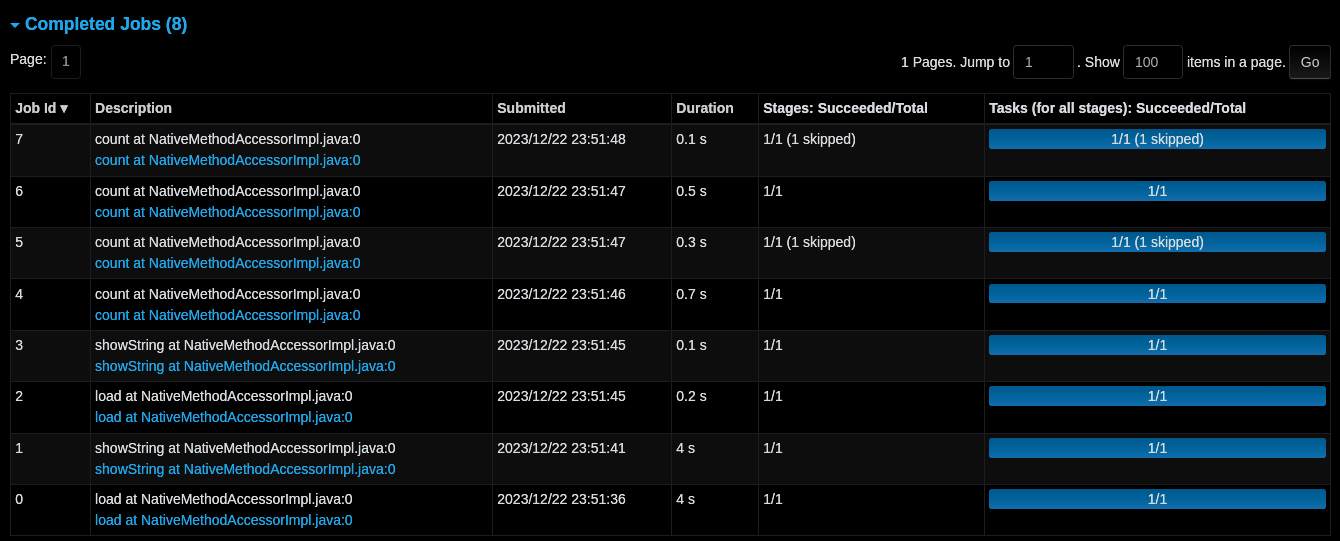

8 jobs have been completed

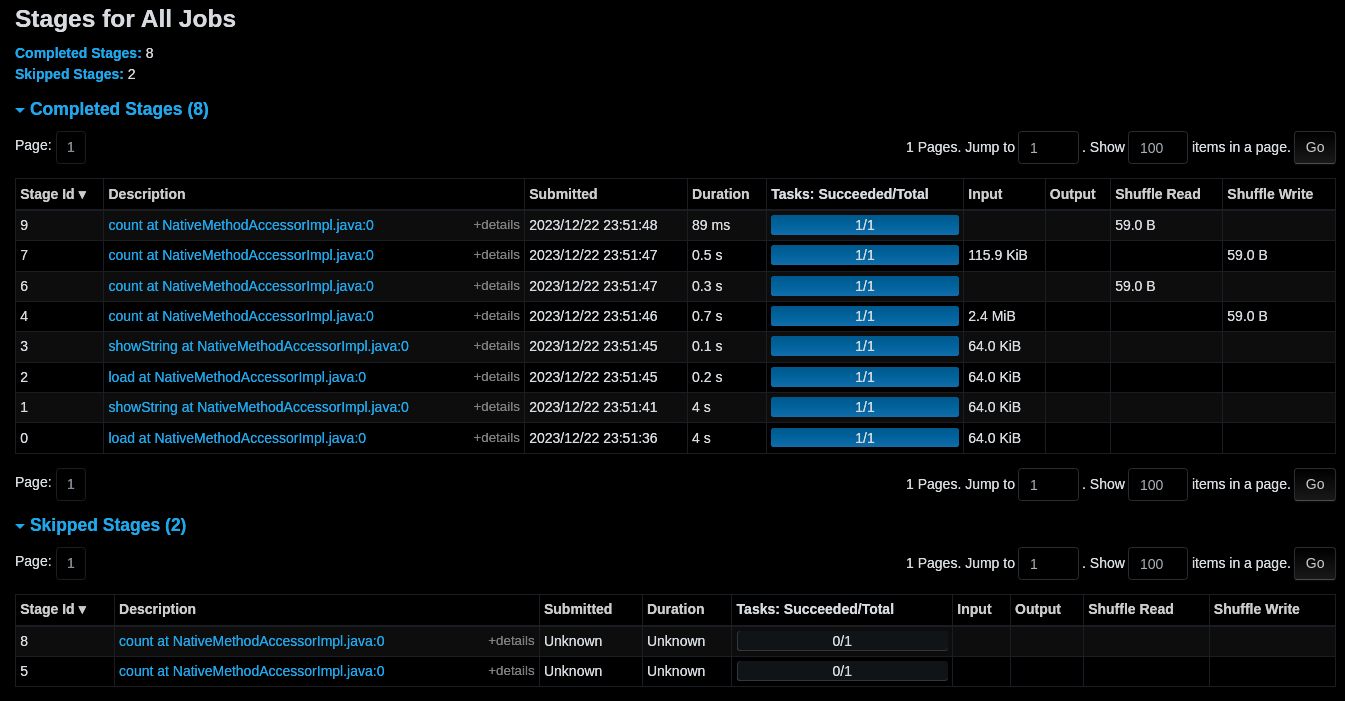

8 stages, 8 tasks have been completed

## Data processing

In [19]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [36]:
ratings_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



Fix scheme ex post facto

In [45]:
ratings_df = ratings_df.withColumn("userId", ratings_df["userId"].cast("int"))\
                       .withColumn("movieId", ratings_df["movieId"].cast("int"))\
                       .withColumn("rating", ratings_df["rating"].cast("double"))\
                       .withColumn("timestamp", ratings_df["timestamp"].cast("bigint"))

In [47]:
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)



In [46]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



### Count unique values on userId and movieID 

In [118]:
ratings_df.select("userId").distinct().count()

610

In [119]:
ratings_df.select("movieId").distinct().count()

9724

### Count number of ratings >= 4.0

In [50]:
ratings_df.filter(ratings_df.rating >= 4.0).count()

48580

### Show the top-100 highest rated movies

In [156]:
ratings_df.groupBy("movieId")\
          .agg(f.avg("rating").alias("avgMovieRating"))\
          .orderBy("avgMovieRating", ascending=False)\
          .show(100) 

+-------+--------------+
|movieId|avgMovieRating|
+-------+--------------+
|  80124|           5.0|
|  74226|           5.0|
| 175387|           5.0|
|    148|           5.0|
| 158027|           5.0|
|  67618|           5.0|
|  42556|           5.0|
| 142444|           5.0|
|  44943|           5.0|
|  27523|           5.0|
| 113829|           5.0|
|   3073|           5.0|
| 152711|           5.0|
| 132333|           5.0|
|     53|           5.0|
|  27704|           5.0|
| 147300|           5.0|
| 187717|           5.0|
|    633|           5.0|
|   8238|           5.0|
|    876|           5.0|
| 120138|           5.0|
|  53578|           5.0|
| 163072|           5.0|
| 160644|           5.0|
| 172909|           5.0|
|   5490|           5.0|
| 172583|           5.0|
|   2972|           5.0|
|   2196|           5.0|
|  25887|           5.0|
| 118834|           5.0|
|   3795|           5.0|
| 156025|           5.0|
|   3941|           5.0|
| 120130|           5.0|
|    626|           5.0|


Would be more clear if __movieId__ is sorted too

In [155]:
ratings_df.groupBy("movieId")\
          .agg(f.avg("rating").alias("avgMovieRating"))\
          .orderBy(["avgMovieRating", "movieId"], ascending=[False, True])\
          .show(100)

+-------+--------------+
|movieId|avgMovieRating|
+-------+--------------+
|     53|           5.0|
|     99|           5.0|
|    148|           5.0|
|    467|           5.0|
|    495|           5.0|
|    496|           5.0|
|    626|           5.0|
|    633|           5.0|
|    876|           5.0|
|   1140|           5.0|
|   1151|           5.0|
|   1310|           5.0|
|   1349|           5.0|
|   1631|           5.0|
|   1759|           5.0|
|   2075|           5.0|
|   2196|           5.0|
|   2512|           5.0|
|   2824|           5.0|
|   2969|           5.0|
|   2972|           5.0|
|   3073|           5.0|
|   3086|           5.0|
|   3096|           5.0|
|   3303|           5.0|
|   3473|           5.0|
|   3496|           5.0|
|   3531|           5.0|
|   3567|           5.0|
|   3637|           5.0|
|   3678|           5.0|
|   3687|           5.0|
|   3792|           5.0|
|   3795|           5.0|
|   3851|           5.0|
|   3939|           5.0|
|   3940|           5.0|


The problem here is that number of users are not taken into account and movies with small amount of ratings presented here. We can get more representative output

In [139]:
minimum_users_num = 10

In [154]:
ratings_df.groupBy("movieId")\
          .agg(f.count("*").alias("ratingsCount"),
               f.avg("rating").alias("avgMovieRating")
          )\
          .where(f.col("ratingsCount") > minimum_users_num)\
          .orderBy(["avgMovieRating", "movieId"], ascending=[False, True])\
          .show(100)

+-------+------------+------------------+
|movieId|ratingsCount|    avgMovieRating|
+-------+------------+------------------+
|   1041|          11| 4.590909090909091|
|   3451|          11| 4.545454545454546|
|   1178|          12| 4.541666666666667|
|   1104|          20|             4.475|
|   2360|          12| 4.458333333333333|
|   1217|          15| 4.433333333333334|
|    318|         317| 4.429022082018927|
|    951|          14| 4.392857142857143|
|    922|          27| 4.333333333333333|
|   3468|          18| 4.333333333333333|
|   3435|          17| 4.323529411764706|
|    905|          14| 4.321428571428571|
|    898|          29| 4.310344827586207|
|    176|          13|4.3076923076923075|
|   7156|          13|4.3076923076923075|
|   1209|          18| 4.305555555555555|
|    475|          25|               4.3|
|   1204|          45|               4.3|
|    246|          29| 4.293103448275862|
|  80906|          12| 4.291666666666667|
|    858|         192|         4.2

Looks better

### Calculate average time difference between tag time and rating time for movie per each user

Load tags correctly from the scratch

In [77]:
from pyspark.sql.types import *
import pyspark.sql.functions as f

In [61]:
tags_schema = StructType([
    StructField("userId", IntegerType(), True), 
    StructField("movieId", IntegerType(), True), 
    StructField("tag", StringType(), True), 
    StructField("timestamp", LongType(), True)])

In [63]:
tags_df = spark.read.csv("/ml-latest-small/tags.csv", header=True, schema=tags_schema)

In [65]:
tags_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: long (nullable = true)



In [64]:
tags_df.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [170]:
ratings_df.join(
    tags_df.withColumnRenamed('timestamp', 'tagTimestamp'),
    ["userId", "movieId"]
).withColumn(
    'diffInSeconds',
    f.to_timestamp(f.from_unixtime("timestamp")).cast("long") \
    - f.to_timestamp(f.from_unixtime("tagTimestamp")).cast("long")
).withColumn(
    'absDiffInSeconds',
    f.abs(
        f.to_timestamp(f.from_unixtime("timestamp")).cast("long") \
        - f.to_timestamp(f.from_unixtime("tagTimestamp")).cast("long")
    )
).select(
    f.avg('diffInSeconds').alias("avgDiffInSeconds"),
    f.avg('absDiffInSeconds').alias("avgAbsDiffInSeconds")
).withColumn("avgDiffInHours", f.round(f.col("avgDiffInSeconds") / 3600))\
 .withColumn("avgAbsDiffInHours", f.round(f.col("avgAbsDiffInSeconds") / 3600))\
 .show()

+--------------------+--------------------+--------------+-----------------+
|    avgDiffInSeconds| avgAbsDiffInSeconds|avgDiffInHours|avgAbsDiffInHours|
+--------------------+--------------------+--------------+-----------------+
|-2.62437273722669...|2.9203715568469506E7|       -7290.0|           8112.0|
+--------------------+--------------------+--------------+-----------------+



### Calculate average rating per user and return average value by all users 

In [146]:
ratings_df.groupBy("userId")\
          .agg(f.avg("rating").alias("avgRating"))\
          .select(f.avg("avgRating").alias("averagedAvgRating"))\
          .show()

+------------------+
| averagedAvgRating|
+------------------+
|3.6572223377474016|
+------------------+

